In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.510387 seconds (14.89 M allocations: 957.793 MiB, 11.93% gc time, 99.28% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
const plt = PyPlot;
using Random, Distributions
using ProgressBars
using DelimitedFiles
Random.seed!(0)


TaskLocalRNG()

Some useful globals

In [88]:
########## Calcium-40 ion ##########
CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

########## Some calibrated values for the Molmer-sorensen gate ##########

Œº_I = 94326.65907221894 # laser-intensity, W/cm^2
Œº_ŒΩ = 2.5e5 # trap-frequency, Hz
Œº_f_cl = 4.111550352057269e14 # laser-frequency, Hz
Œº_œï = 0.0 # relative phase between red and blue sidebands 
MS_œÄ2_TIME = 1e-4 # gate-time for an MS(œÄ/2) gate
AC_CORRECTION = 0 # ac-stark shift correction, Hz
B_STRENGTH = 6e-4 # magnetic field strength, T

########## Some useful quantum states ##########

# Computational basis
ket_00 = CALCIUM40["S"] ‚äó CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ‚äó CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ‚äó CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ‚äó CALCIUM40["D"]
œÅ_00 = dm(ket_00)
œÅ_01 = dm(ket_01)
œÅ_10 = dm(ket_10)
œÅ_11 = dm(ket_11)

# Bell basis
ket_00_m_i11 = (ket_00 - 1im*ket_11)/‚àö2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/‚àö2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/‚àö2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/‚àö2
œÅ_00_m_i11 = dm(ket_00_m_i11)
œÅ_00_p_i11 = dm(ket_00_p_i11)
œÅ_01_m_i10 = dm(ket_01_m_i10)
œÅ_01_p_i10 = dm(ket_01_p_i10);


Helper function for plotting state populations

In [106]:
function plot_populations(chamber, tout, sol)

    ket0_vib_mode = IonSim.modes(chamber)[1][0]
    dm0_vib_mode = dm(ket0_vib_mode)

    # compute expectation values
    prob_00 = expect(œÅ_00 ‚äó dm0_vib_mode , sol)  # ùîº(|S‚ü©|S‚ü©)
    prob_11 = expect(œÅ_11 ‚äó dm0_vib_mode, sol)  # ùîº(|D‚ü©|D‚ü©)
    prob_01 = expect(œÅ_01 ‚äó dm0_vib_mode, sol)  # ùîº(|S‚ü©|D‚ü©)
    prob_10 = expect(œÅ_10 ‚äó dm0_vib_mode, sol)  # ùîº(|D‚ü©|S‚ü©)
    prob_00_p_i11 = expect(œÅ_00_p_i11 ‚äó dm0_vib_mode, sol)  # ùîº(|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)
    prob_00_m_i11 = expect(œÅ_00_m_i11 ‚äó dm0_vib_mode, sol)  # ùîº(|S‚ü©|S‚ü© - i|D‚ü©|D‚ü©)
    prob_01_p_i10 = expect(œÅ_01_p_i10 ‚äó dm0_vib_mode, sol)  # ùîº(|S‚ü©|D‚ü© + i|D‚ü©|S‚ü©)
    prob_01_m_i10 = expect(œÅ_01_m_i10 ‚äó dm0_vib_mode, sol)  # ùîº(|S‚ü©|D‚ü© - i|D‚ü©|S‚ü©)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (Œºs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (Œºs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")

    return fig
end

plot_populations (generic function with 1 method)

In [158]:
function construct_two_ion_chamber(
    I, # Intensity, W/m^2
    ŒΩ, # Trap-frequency, Hz
    ŒΩ_target, # Target trap-frequency for computing the sideband detuning, Hz
    f_cl, # Center-line frequency, Hz
    œï # Relative phase between red and blue sidebands, radian
    ;
    B = 6e-4,# Strength of magnetic field, T
    ms_œÄ2_time = 1e-4,# Time for an MS(œÄ/2) gate, determines the detuning, s
    ac_correction = 0# AC Stark shift correction, Hz
)
    """
    YOU MUST UPDATE ALL THE LASER PARAMETERS IN ORDER TO PERFORM SINGLE-QUBIT GATES.

    By default, this function builds a chamber that is ready to perform a Molmer-Sorensen gate, i.e. the 
    sideband detuning is set such that it couples the internal electronic-states to the motional-modes of 
    the ion-chain. 

    The single-qubit gates require zero sideband detuning.
    """
    ######### Ion-chain #########
    chain = LinearChain(
        ions = [Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies = (x = 3e6, y = 3e6, z = ŒΩ), 
        selectedmodes = (;z = [1],) # <-- Currently only support for axial modes
    )

    ######### Molmer-Sorensen lasers #########

    # Compute the laser wavelength
    C0 = 2.99792458e8
    Œª_cl = C0/f_cl

    # Compute the sideband detuning 
    Œ¥ = ŒΩ_target + 1/ms_œÄ2_time - ac_correction
    Œî_blue = Œ¥
    Œî_red = -Œ¥

    # Compute pointing vectors
    pointing = [(1, 1.), (2, 1.)]
    # This is NOT the same thing as the Poynting vector
    # pointing::tuple = (integer: index of ion, float: amplitude at position of that ion (as a fraction of the intensity))

    laser_red = Laser(Œª=Œª_cl, I=I, Œî=Œî_red, œµ=xÃÇ, k=zÃÇ, œï=œï, pointing=pointing)
    laser_blue = Laser(Œª=Œª_cl, I=I, Œî=Œî_blue, œµ=xÃÇ, k=zÃÇ, œï=0, pointing=pointing)
    
    ######### Chamber #########
    chamber = Chamber(iontrap=chain, B=B, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser_red, laser_blue]);
    return chamber
end

function prep_for_single_qubit_gate(chamber, ion_idx)
    """
    This function accepts a chamber that is already primed to perform an MS gate. 

    It updates the parameters of the lasers to perform the RX gate on the ion specified by `ion_idx`. 

    It also returns the original laser parameters so that they can be reset after the single-qubit gate is performed.

    """
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]
    laser_ignore = chamber.lasers[laser_update_idx%2 + 1]

    # Collect the original laser parameters
    og_params = Dict(
        "updated_laser_idx" => laser_update_idx,
        "Œª" => laser_update.Œª,
        "I_updated" => laser_update.I,
        "I_ignored"=> laser_ignore.I,
        "Œî" => laser_update.Œî,
        "œï" => laser_update.œï,
        "œµ" => laser_update.œµ,
        "k" => laser_update.k,
        "pointing" => laser_update.pointing
    ),
        
    # Update the laser parameters
    detuning!(laser_update, 0)

    Œª_tr = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
    wavelength!(laser_update, Œª_tr)

    intensity!(laser_update, intensity_from_pitime(laser_1, MS_œÄ2_TIME, CALCIUM40, ("S", "D"), chamber_1))
    intensity!(laser_ignore, 0)

    polarization!(laser_update, xÃÇ)

    wavevector!(laser_update, zÃÇ)

    pointing!(laser_update, [(ion_idx, 1.), (ion_idx%2+1, 0.)])
    
    return og_params

end

function restore_og_params(chamber, og_params)
    updated_laser_idx = og_params["updated_laser_idx"]
    laser_updated = chamber.lasers[updated_laser_idx]
    laser_ignored = chamber.lasers[updated_laser_idx%2 + 1]

    wavelength!(laser_updated, og_params["Œª"])
    intensity!(laser_updated, og_params["I_updated"])
    intensity!(laser_ignored, og_params["I_ignored"])
    detuning!(laser_updated, og_params["Œî"])
    phase!(laser_updated, og_params["œï"])
    polarization!(laser_updated, og_params["œµ"])
    wavevector!(laser_updated, og_params["k"])
    pointing!(laser_updated, og_params["pointing"])

end

function RX(chamber, ion_idx, Œ∏, œà0, pi_time, timescale)

    """
    This function accepts a chamber that is already primed to perform an MS gate. 

    It updates the parameters of the lasers to perform the RX gate on the ion specified by `ion_idx`. 

    Then it performs the specified RX gate on this ion: with the angle `Œ∏`, starting from the initial state `œà0`.

    Finally, it resets the laser parameters back to their original values.

    """

    # Update the laser parameters
    og_params = prep_for_single_qubit_gate(chamber, ion_idx) # Update the laser parameters, this in-place for the 'chamber' object

    # Set the necessary phase for the RX gate
    laser_update_idx = ion_idx
    laser_update = chamber.lasers[laser_update_idx]
    phase!(laser_update, 0)

    # Perform the RX gate
    h = hamiltonian(chamber, timescale=timescale)
    t_final = (Œ∏/œÄ)*pi_time
    t_range = 0:t_final/100:t_final
    tout, œàt = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h)

    # Reset the laser parameters
    restore_og_params(chamber, og_params)

    return tout, œàt

end

RX (generic function with 2 methods)

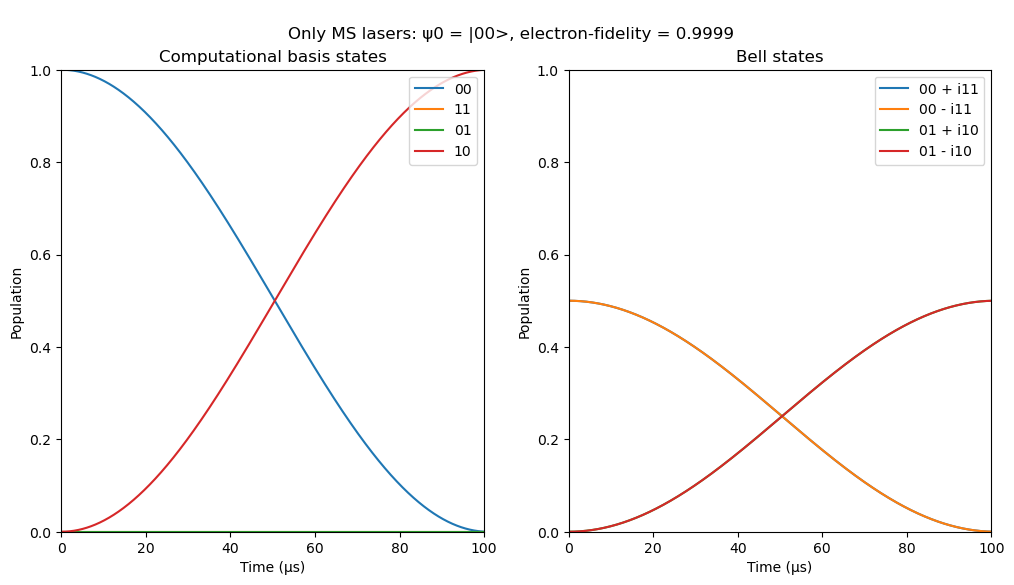

In [165]:
chain_2i = construct_two_ion_chamber(Œº_I, Œº_ŒΩ, Œº_ŒΩ, Œº_f_cl, Œº_œï, B=B_STRENGTH, ms_œÄ2_time=MS_œÄ2_TIME, ac_correction=AC_CORRECTION);

og_params = prep_for_single_qubit_gate(chain_2i, 1);

ket0_vib_mode= IonSim.modes(chamber_2i)[1][0] # ground state of first vibrational mode
dm0_vib_mode = dm(ket0_vib_mode)

h = hamiltonian(chamber_2i, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
tout00, sol00 = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, dm(ket_10))), digits=4)
fig = plot_populations_double(chamber_2i, tout00, sol00)
fig.suptitle("\nOnly MS lasers: œà0 = |00>, electron-fidelity = $fid")
plt.display(fig)
plt.close(fig)

# 1. Test if single-qubit noise is the same whether single-ion or two-ion chain

In [166]:
Œ©_opt = 1e7
Œ∫ = Œº_I/(Œ©_opt^2)
œÉŒ© = 0.2Œ©_opt
œÉ_I = Œ∫*sqrt(2*(œÉŒ©^4) + 4*(œÉŒ©^2)*Œ©_opt^2 )
Normal_I = Normal(Œº_I, œÉ_I)

œÉ_f_cl = 2e3
Normal_f_cl = Normal(Œº_f_cl, œÉ_f_cl)

œÉ_ŒΩ = 2e3
Normal_ŒΩ = Normal(Œº_ŒΩ, œÉ_ŒΩ)

œÉ_œï = 0.16*œÄ;
Normal_œï = Normal(Œº_œï, œÉ_œï);

N_SAMPLES = Int(1e3)
Œò = zeros(N_SAMPLES, 4)

for i in 1:N_SAMPLES
    Œò[i, 1] = rand(Normal_I)
    Œò[i, 2] = rand(Normal_f_cl)
    Œò[i, 3] = rand(Normal_ŒΩ)
    Œò[i, 4] = rand(Normal_œï)
end

## 1.a. Two-ion chain

In [174]:
fidelities_2i = zeros(N_SAMPLES)
for i in 1:N_SAMPLES
    try
        I_i = Œò[i, 1]
        f_cl_i = Œò[i, 2]
        ŒΩ_i = Œò[i, 3]
        œï_i = Œò[i, 4]
        # Construct two-qubit chamber
        chamber_2i = construct_two_ion_chamber(I_i, ŒΩ_i, Œº_ŒΩ, f_cl_i, œï_i, B=B_STRENGTH, ms_œÄ2_time=MS_œÄ2_TIME, ac_correction=AC_CORRECTION);

        # Prep it for single-ion gate
        og_params = prep_for_single_qubit_gate(chain_2i, 1);

        # Run the simulation
        h = hamiltonian(chamber_2i, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
        œÅ_final = ptrace(dm(sol00[end]), 3)
        fid = round(real(fidelity(œÅ_final, dm(ket_10))), digits=4)

        fidelities_2i[i] = fid
    catch
        fidelities_2i[i] = NaN
    end
end

In [175]:
fidelities_2i = fidelities_2i[.!isnan.(fidelities_2i)]
length(fidelities_2i)

989

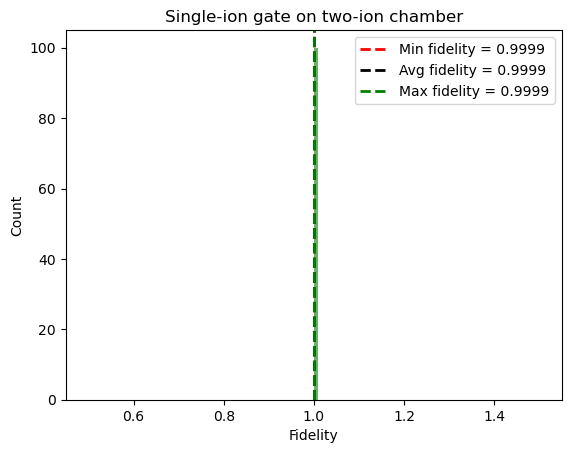

In [176]:
fig = plt.figure()
plt.hist(fidelities_2i, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_2i), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_2i); digits=8))")
plt.axvline(mean(fidelities_2i), color="k", linestyle="--", linewidth=2, label="Avg fidelity = $(round(mean(fidelities_2i); digits=8))")
plt.axvline(maximum(fidelities_2i), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_2i); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Single-ion gate on two-ion chamber")
plt.legend()
plt.display(fig)

## 1.b. Single-ion chain

In [ ]:
function construct_single_qubit_chamber(
    # Ion-chain parameters
    trap_frequency,

    # Laser parameters
    pi_time;

    # Trap parameters

    # Default laser parameters
    intensity = Nothing,
    wavelength = Nothing,

    # Default trap parameters
    B_strength = Nothing
)

chain = LinearChain(
    ions = [CALCIUM40], 
    comfrequencies = (x = 3e6, y = 3e6, z = trap_frequency), 
    selectedmodes = (;z = [1],)
)

laser = Laser(Œî=0, œµ = (xÃÇ - zÃÇ)/‚àö2, k = (xÃÇ + zÃÇ)/‚àö2, œï = 0)

if B_strength == Nothing
    B_strength = 4e-4
end
chamber = Chamber(iontrap=chain, B=B_strength, Bhat=zÃÇ, Œ¥B=0, lasers=[laser]);

if wavelength == Nothing
    Œª = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
else
    Œª = wavelength
end
wavelength!(laser, Œª)

if intensity == Nothing
    I = intensity_from_pitime(laser, pi_time, CALCIUM40, ("S", "D"), chamber)
else
    I = intensity
end
intensity!(laser, I)


return chamber

end

# 2.

RX (generic function with 2 methods)

In [ ]:
chamber = construct_two_qubit_chamber(Œº_I, Œº_ŒΩ, Œº_f_cl, Œº_œï, B = B_STRENGTH, ms_œÄ2_time = MS_œÄ2_TIME, ac_correction = AC_CORRECTION)

œà0 = ket_00 ‚äó IonSim.modes(chamber)[1][0]


# 2. Perform an RX gate

Functions to construct a two-ion chamber, perform a Molmer-Sorensen (two-qubit entangling gate), and single-qubit gates

In [89]:
function construct_two_qubit_chamber(
    I, # Intensity, W/m^2
    ŒΩ, # Trap-frequency, Hz
    f_cl, # Center-line frequency, Hz
    œï, # Relative phase between red and blue sidebands, radian
    B, # Strength of magnetic field, T
    ms_œÄ2_time, # Time for an MS(œÄ/2) gate, determines the detuning, s
    ac_correction # AC Stark shift correction, Hz
)
    """By default, this builds a chamber ready to perform a Molmer-Sorensen gate, i.e. the sideband detuning is set in order to couple
    the internal electronic-states to the motional-modes of the ion-chain. The single-qubit gates below require no such coupling. """
    ######### Ion-chain #########
    chain = LinearChain(
        ions = [Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies = (x = 3e6, y = 3e6, z = ŒΩ), 
        selectedmodes = (;z = [1],)
    )

    ######### Molmer-Sorensen lasers #########

    # Compute the laser wavelength
    C0 = 2.99792458e8
    Œª_cl = C0/f_cl

    # Compute the sideband detuning 
    Œ¥ = ŒΩ + 1/ms_œÄ2_time - ac_correction
    Œî_blue = Œ¥
    Œî_red = -Œ¥

    # Compute pointing vectors
    pointing = [(1, 1.), (2, 1.)]
    # This is NOT the same thing as the Poynting vector
    # pointing::tuple = (integer: index of ion, float: amplitude at position of that ion (as a fraction of the intensity))

    laser_red = Laser(Œª=Œª_cl, I=I, Œî=Œî_red, œµ=xÃÇ, k=zÃÇ, œï=œï, pointing=pointing)
    laser_blue = Laser(Œª=Œª_cl, I=I, Œî=Œî_blue, œµ=xÃÇ, k=zÃÇ, œï=0, pointing=pointing)
    
    ######### Chamber #########
    chamber = Chamber(iontrap=chain, B=B_strength, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);
    return chamber
end

function MS(chamber, Œ∏, ms_œÄ2_time;  # Molmer-Sorensen gate, Œ∏=œÄ/2 for fully-entangling MS gate
    timescale=1e-6)

    gate_time = ms_œÄ2_time * Œ∏/(œÄ/2)
    t_range = 0:gate_time*1e-3:gate_time # TODO: soft-code the time-step

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf); # TODO: soft-code lamb_dicke_order, rwa_cutoff

    @time tout, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h);
end





MS (generic function with 1 method)

# 1. Testing error

In [120]:
chamber_1.lasers[1].pointing

2-element Vector{Tuple{Int64, Float64}}:
 (1, 1.0)
 (2, 0.0)

In [121]:
intensity!(chamber.lasers[1], chamber.lasers[2].I)

(::IonSim.var"#It#31"{Float64}) (generic function with 1 method)

plot_populations_double (generic function with 1 method)

In [91]:
T_RANGE = 0:MS_œÄ2_TIME*1e-3:MS_œÄ2_TIME
TIMESCALE = 1e-6 # seconds 

1.0e-6

## 1.a. Chamber only has MS lasers

In [123]:
############### Ion chain ###############
chain_1 = LinearChain(
        ions = [CALCIUM40, CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = Œº_ŒΩ), 
        selectedmodes = (;z = [1],)
    )

############### MS lasers ##############

# Compute the laser wavelength
C0 = 2.99792458e8
Œª_cl = C0/Œº_f_cl

# Compute the sideband detuning 
Œ¥ = Œº_ŒΩ + 1/MS_œÄ2_TIME - AC_CORRECTION
Œî_blue = Œ¥
Œî_red = -Œ¥

# Compute pointing vectors
pointing = [(1, 1.), (2, 1.)]
# This is NOT the same thing as the Poynting vector
# pointing::tuple = (integer: index of ion, float: amplitude at position of that ion (as a fraction of the intensity))

laser_red = Laser(Œª=Œª_cl, I=Œº_I, Œî=Œî_red, œµ=xÃÇ, k=zÃÇ, œï=Œº_œï, pointing=pointing)
laser_blue = Laser(Œª=Œª_cl, I=Œº_I, Œî=Œî_blue, œµ=xÃÇ, k=zÃÇ, œï=0, pointing=pointing)

############### Chamber ###############

chamber_1 = Chamber(iontrap=chain_1, B=B_STRENGTH, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser_red, laser_blue]);

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:107


In [127]:
phase!(chamber.lasers[1], chamber.lasers[2].œï)

(::IonSim.var"#œït#32"{Int64}) (generic function with 1 method)

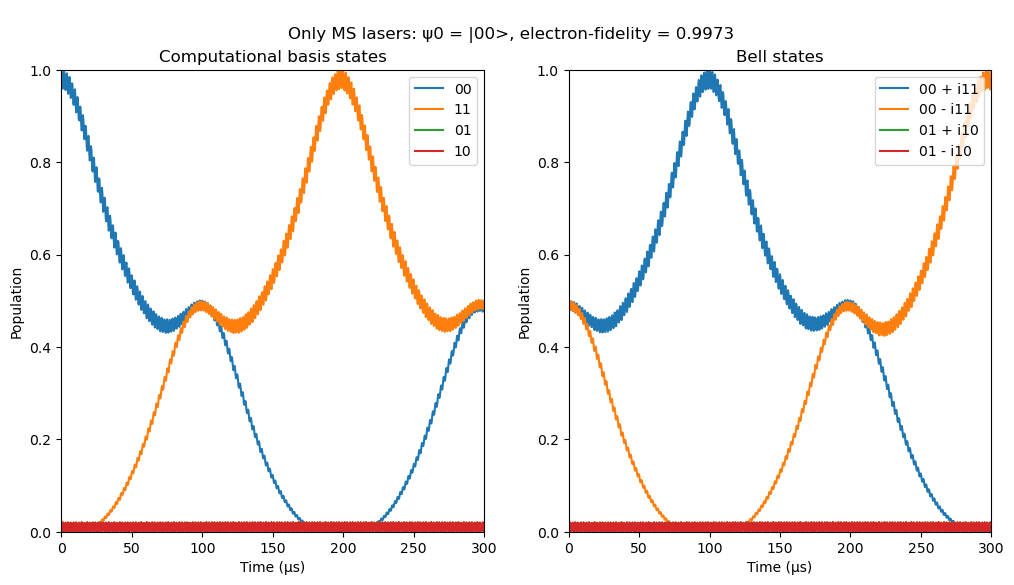

  0.302681 seconds (5.23 M allocations: 198.610 MiB, 5.76% gc time)


In [128]:
ket0_vib_mode= IonSim.modes(chamber_1)[1][0] # ground state of first vibrational mode
dm0_vib_mode = dm(ket0_vib_mode)

h = hamiltonian(chamber_1, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, œÅ_00_m_i11)), digits=4)
fig = plot_populations_double(chamber_1, tout00, sol00)
fig.suptitle("\nOnly MS lasers: œà0 = |00>, electron-fidelity = $fid")
plt.display(fig)
plt.close(fig)

In [112]:
detuning!(chamber_1.lasers[1], 0)
detuning!(chamber_1.lasers[2], 0)

Œª_tr = transitionwavelength(CALCIUM40, ("S", "D"), chamber_1)
wavelength!(chamber_1.lasers[1], Œª_tr)
wavelength!(chamber_1.lasers[2], Œª_tr)

intensity!(chamber_1.lasers[1], intensity_from_pitime(chamber_1.lasers[1], MS_œÄ2_TIME, CALCIUM40, ("S", "D"), chamber_1))
intensity!(chamber_1.lasers[2], intensity_from_pitime(chamber_1.lasers[1], MS_œÄ2_TIME, CALCIUM40, ("S", "D"), chamber_2))

polarization!(chamber_1.lasers[1], xÃÇ)
polarization!(chamber_1.lasers[2], xÃÇ)

wavevector!(chamber_1.lasers[1], zÃÇ)
wavevector!(chamber_1.lasers[2], zÃÇ)

pointing!(chamber_1.lasers[1], [(1, 1.), (2, 0.)])
pointing!(chamber_1.lasers[2], [(1, 0.), (2, 1.)])

2-element Vector{Tuple{Int64, Float64}}:
 (1, 0.0)
 (2, 1.0)

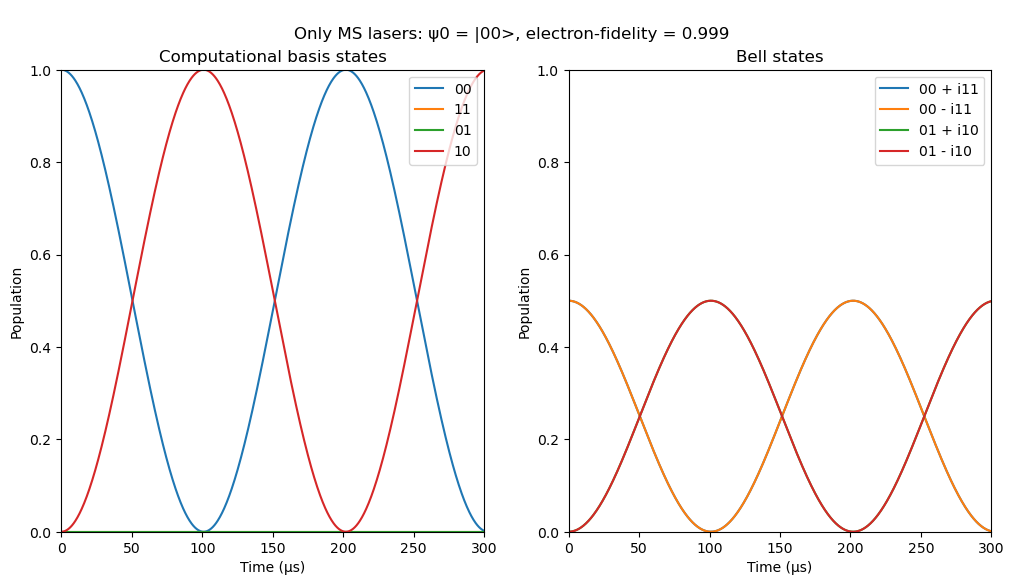

  0.024988 seconds (708.89 k allocations: 19.412 MiB)


In [113]:
intensity!(chamber_1.lasers[2], 0)
ket0_vib_mode= IonSim.modes(chamber_1)[1][0] # ground state of first vibrational mode
dm0_vib_mode = dm(ket0_vib_mode)

h = hamiltonian(chamber_1, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, dm(ket_10))), digits=4)
fig = plot_populations_double(chamber_1, tout00, sol00)
fig.suptitle("\nOnly MS lasers: œà0 = |00>, electron-fidelity = $fid")
plt.display(fig)
plt.close(fig)

## 1.b. Chamber has both MS and single-qubit lasers, but single-qubit lasers are turned off

In [62]:
############### Ion chain ###############
chain_2 = LinearChain(
        ions = [CALCIUM40, CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = Œº_ŒΩ), 
        selectedmodes = (;z = [1],)
    )

############### MS lasers ##############

# Compute the laser wavelength
C0 = 2.99792458e8
Œª_cl = C0/Œº_f_cl

# Compute the sideband detuning 
Œ¥ = Œº_ŒΩ + 1/MS_œÄ2_TIME - AC_CORRECTION
Œî_blue = Œ¥
Œî_red = -Œ¥

# Compute pointing vectors
pointing = [(1, 1.), (2, 1.)]
# This is NOT the same thing as the Poynting vector
# pointing::tuple = (integer: index of ion, float: amplitude at position of that ion (as a fraction of the intensity))

laser_red = Laser(Œª=Œª_cl, I=Œº_I, Œî=Œî_red, œµ=xÃÇ, k=zÃÇ, œï=Œº_œï, pointing=pointing)
laser_blue = Laser(Œª=Œª_cl, I=Œº_I, Œî=Œî_blue, œµ=xÃÇ, k=zÃÇ, œï=0, pointing=pointing)

############### Single-qubit lasers ##############
laser_1 = Laser(Œî=0, œµ = (xÃÇ - zÃÇ)/‚àö2, k = (xÃÇ + zÃÇ)/‚àö2, œï = 0, pointing = [(1,1.), (2,0.)])
laser_2 = Laser(Œî=0, œµ = (xÃÇ - zÃÇ)/‚àö2, k = (xÃÇ + zÃÇ)/‚àö2, œï = 0, pointing = [(1,0.), (2,1.)])

############### Chamber ###############

chamber_2 = Chamber(iontrap=chain_2, B=B_STRENGTH, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser_1, laser_2, laser_red, laser_blue]);

Œª_tr = transitionwavelength(CALCIUM40, ("S", "D"), chamber_2)
wavelength!(laser_1, Œª_tr)
wavelength!(laser_2, Œª_tr)

intensity!(chamber_2.lasers[1], intensity_from_pitime(chamber_2.lasers[1], MS_œÄ2_TIME, CALCIUM40, ("S", "D"), chamber_2))
intensity!(chamber_2.lasers[2], intensity_from_pitime(chamber_2.lasers[2], MS_œÄ2_TIME, CALCIUM40, ("S", "D"), chamber_2))

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:107


#33 (generic function with 1 method)

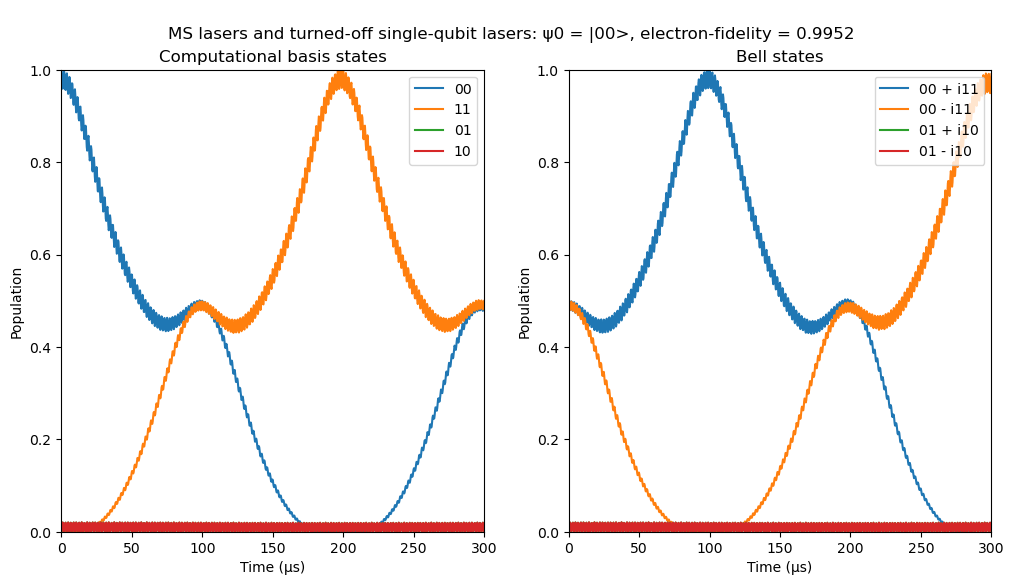

  0.524527 seconds (8.71 M allocations: 350.321 MiB, 9.87% gc time)


In [54]:
intensity!(chamber_2.lasers[1],0)
intensity!(chamber_2.lasers[2],0)

ket0_vib_mode= IonSim.modes(chamber_2)[1][0] # ground state of first vibrational mode
dm0_vib_mode = dm(ket0_vib_mode)

h = hamiltonian(chamber_2, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, œÅ_00_m_i11)), digits=4)
fig = plot_populations_double(chamber_2, tout00, sol00)
fig.suptitle("\nMS lasers and turned-off single-qubit lasers: œà0 = |00>, electron-fidelity = $fid")
plt.display(fig)
plt.close(fig)

RX only on ion-1

In [63]:
#intensity!(chamber_2.lasers[1], 0)
#intensity!(chamber_2.lasers[2], 0)
intensity!(chamber_2.lasers[3], 0)
intensity!(chamber_2.lasers[4], 0)

h = hamiltonian(chamber_2, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);
@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_vib_mode, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, œÅ_00_m_i11)), digits=4)
fig = plot_populations_double(chamber_2, tout00, sol00)
fig.suptitle("\nMS lasers and turned-off single-qubit lasers: œà0 = |00>, electron-fidelity = $fid")
plt.display(fig)
plt.close(fig)

  0.001593 seconds (4.66 k allocations: 275.227 KiB)


‚îå Warning: First function call produced NaNs. Exiting. Double check that none of the initial conditions, parameters, or timespan values are NaN.
‚îî @ OrdinaryDiffEq /home/aelabd/.julia/packages/OrdinaryDiffEq/Knuk0/src/initdt.jl:131
‚îå Warning: At t=0.0, dt was forced below floating point epsilon 5.0e-324, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of ComplexF64).
‚îî @ SciMLBase /home/aelabd/.julia/packages/SciMLBase/sakPO/src/integrator_interface.jl:633


BoundsError: BoundsError: attempt to access 0-element Vector{Ket{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, Vector{ComplexF64}}} at index [0]

In [50]:
sol00

Ket{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, Vector{ComplexF64}}[]